# Проект по машинному обучению





### Описание задачи:

**Цель**- использовать имеющиеся данные для построения модели, которая прогнозирует среднюю температуру для города Аустин(эти данные мы используем при выполнении задания)

Данные уже включают в себя среднюю температуру за предыдущие измерения, нам известны признаки и цель, также нам известна задача - необходимо обучить модель, которая сможет сопоставить признаки с целью. Наша задача - машинное обучение с управляемой регрессией(- значение средней температуры).



### Используемые библиотеки:

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2900706d906d7db92ea5737b72110bd26e1433fdb2a19b838b9a8e5717f231db
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
import lime
import lime.lime_tabular

## Описание набора данных

Загрузили данные.

In [ ]:
url = 'https://drive.usercontent.google.com/u/0/uc?id=1KJmJfYOAq_gRaDqjimWqXc8dO7Vb7cHe-&export=download'
data = pd.read_csv(url)
df = pd.DataFrame(data)
df.head()
#https://drive.google.com/file/d/1KJmJfYOAq_gRaDqjimWqXc8dO7Vb7cHe/view?usp=sharing


NameError: name 'pd' is not defined

Получили таблицу из 21 колонки.
Date - дата,	TempHighF - самая высокая температура,	TempAvgF - средняя температура за день,	TempLowF - самая низкая температура, 	DewPointHighF - самое высокое значение температуры газа, при которой водяной пар, содержащийся в газе, охлаждаемом изобарически, становится насыщенным над плоской поверхностью воды	DewPointAvgF - среднее и  	DewPointLowF - самое низкое,	HumidityHighPercent	- самое высокое значение влажности, HumidityAvgPercent - среднее,	HumidityLowPercent - самое низкое, SeaLevelPressureLowInches	- давление на уровне моря,VisibilityHighMiles	- видимость самая высокая в милях, VisibilityAvgMiles - средняя видимость в милях,	VisibilityLowMiles - самая низкая,	WindHighMPH- самая высокая скорость ветра, WindAvgMPH - средняя скорость,	WindGustMPH - порыв ветра в час, PrecipitationSumInches -сумма осадков, 	Events - события(туман, град и прочее).

## Предварительная обработка

Очищаем данные.

In [ ]:
data = data.replace({'Not Available': np.nan})
data = data.replace({'-': np.nan})
data = data.replace({'T': np.nan})
print(data.columns)
columns_to_skip = ['Date', 'Events']
for col in list(data.columns):
    if col not in columns_to_skip:
        data[col] = data[col].astype(float)

Index(['Date', 'TempHighF', 'TempAvgF', 'TempLowF', 'DewPointHighF',
       'DewPointAvgF', 'DewPointLowF', 'HumidityHighPercent',
       'HumidityAvgPercent', 'HumidityLowPercent',
       'SeaLevelPressureHighInches', 'SeaLevelPressureAvgInches',
       'SeaLevelPressureLowInches', 'VisibilityHighMiles',
       'VisibilityAvgMiles', 'VisibilityLowMiles', 'WindHighMPH', 'WindAvgMPH',
       'WindGustMPH', 'PrecipitationSumInches', 'Events'],
      dtype='object')


Добавим столбец, в котором будет хранится месяц замера, так как, предположительно, месяц играет значение в предсказании температуры.

In [ ]:
month = [i[5:7] for i in data['Date']]
data['Month'] = month
data.to_csv('austin_weather.csv', index=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        1319 non-null   object 
 1   TempHighF                   1319 non-null   float64
 2   TempAvgF                    1319 non-null   float64
 3   TempLowF                    1319 non-null   float64
 4   DewPointHighF               1312 non-null   float64
 5   DewPointAvgF                1312 non-null   float64
 6   DewPointLowF                1312 non-null   float64
 7   HumidityHighPercent         1317 non-null   float64
 8   HumidityAvgPercent          1317 non-null   float64
 9   HumidityLowPercent          1317 non-null   float64
 10  SeaLevelPressureHighInches  1316 non-null   float64
 11  SeaLevelPressureAvgInches   1316 non-null   float64
 12  SeaLevelPressureLowInches   1316 non-null   float64
 13  VisibilityHighMiles         1307 

Переводим данные в формат, с которым удобно работать

In [ ]:
for col in list(data.columns):
    if 'Date' not in col and 'Events' not in col:
        try:
            data[col] = data[col].astype(float)

        except ValueError:
            print(f"Could not convert column '{col}' to float")
            continue

## Постановка задачи и построение модели


**Задача** - понять какие из факторов наиболее влияют на температуру и построить модель для предсказания температуры(средней за день)





### Производим разведочный анализ данных.


Построим гистограмму.

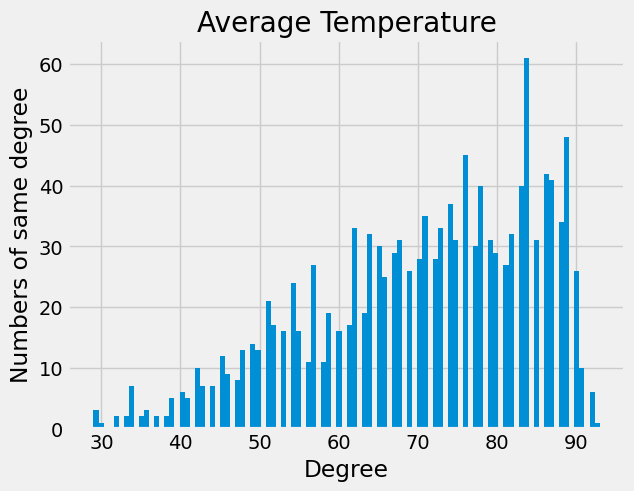

In [ ]:
plt.style.use('fivethirtyeight')
plt.hist(df['TempAvgF'].dropna(), bins = 100);
plt.xlabel('Degree'); plt.ylabel('Numbers of same degree');
plt.title('Average Temperature');

Аномалий не наблюдается, распределение можно считать скорее единообразным, чем нет.

Попробуем искать взаимосвязи. Одним из способов это сделать является построение графика плотностей в зависимости от группы, к которой принадлежит измерение.

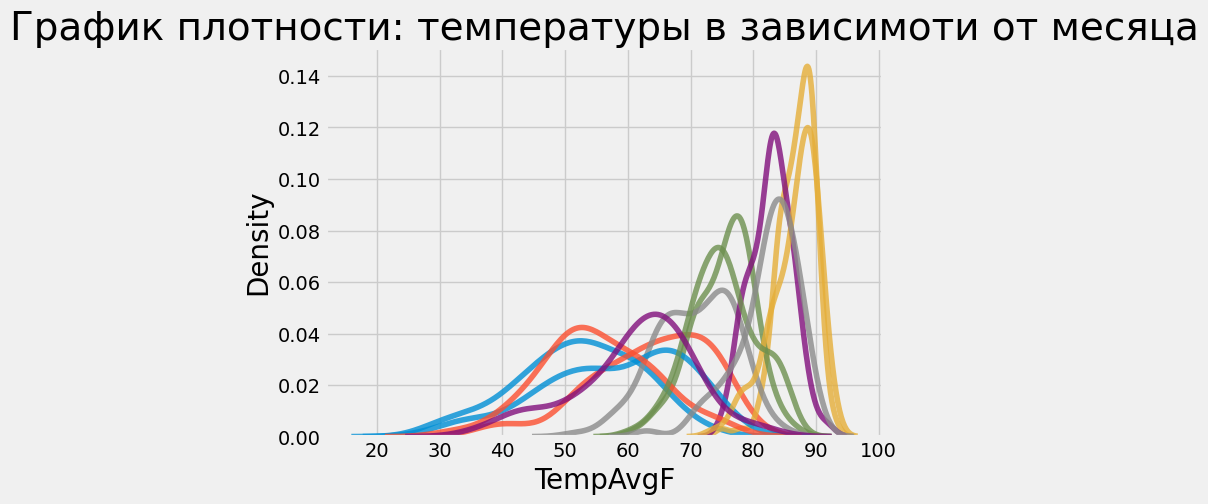

In [ ]:
# Создаём список измерений температуры за каждый месяц, где измерений было больше 50

types = data.dropna(subset=['TempAvgF'])
types = types['Month'].value_counts()
types = list(types[types.values > 10].index)

#Строим график каждой группы
for b_type in types:

    subset = data[data['Month'] == b_type]
    sns.kdeplot(subset['TempAvgF'].dropna(),
               label=b_type, fill=False, alpha=0.8)

plt.xlabel('TempAvgF', size=20)
plt.ylabel('Density', size=20)
plt.title('График плотности: температуры в зависимоти от месяца', size=28)
plt.show()

Видим очень сильные различия групп. Значит, на температуру влияет месяц измерения. Посмотрим, как будет выглядеть график, где различия не большие, в сравнении.

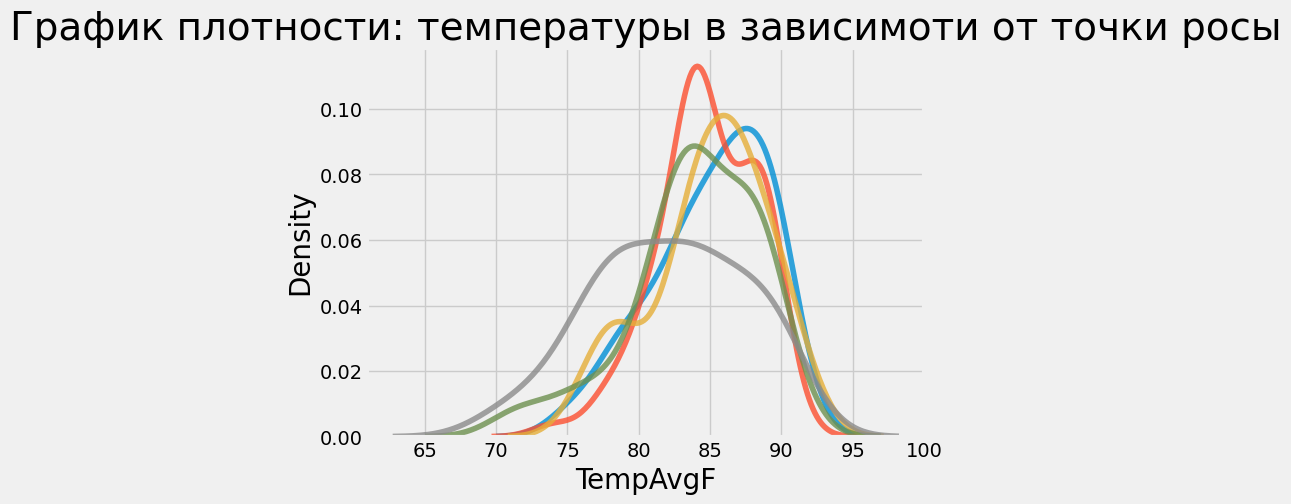

In [ ]:
types = data.dropna(subset=['TempAvgF'])
types = types['DewPointAvgF'].value_counts()
types = list(types[types.values > 50].index)

for b_type in types:

    subset = data[data['DewPointAvgF'] == b_type]
    sns.kdeplot(subset['TempAvgF'].dropna(),
               label=b_type, fill=False, alpha=0.8)

plt.xlabel('TempAvgF', size=20)
plt.ylabel('Density', size=20)
plt.title('График плотности: температуры в зависимоти от точки росы', size=28)
plt.show()

Корреляции между различными парами переменных и распредедлением одиночных переменных. Мы можем использовать коэффициент корреляции Пирсона. Это мера направления и силы линейной зависимости между двумя переменными: значение -1 означает, что значения идеально негативно линейно зависят друг от друга, и следовательно +1 - идеально линейно зависят.

In [ ]:

numeric_data = data.select_dtypes(include=[np.number])
correlations_data = numeric_data.corr()['TempAvgF'].sort_values()

print(correlations_data)


SeaLevelPressureHighInches   -0.695499
SeaLevelPressureAvgInches    -0.623943
SeaLevelPressureLowInches    -0.538093
HumidityLowPercent           -0.092250
PrecipitationSumInches       -0.021149
WindHighMPH                   0.022184
HumidityAvgPercent            0.032456
WindGustMPH                   0.036004
WindAvgMPH                    0.039365
VisibilityHighMiles           0.091353
VisibilityLowMiles            0.113638
VisibilityAvgMiles            0.210172
HumidityHighPercent           0.215363
Month                         0.238901
DewPointLowF                  0.864138
DewPointHighF                 0.881771
DewPointAvgF                  0.895469
TempLowF                      0.968573
TempHighF                     0.970655
TempAvgF                      1.000000
Name: TempAvgF, dtype: float64


Получили такие коэффициенты. Можем сделать вывод, что средняя температура больше всего зависит от самой низкой и самой высокой температуры(температура зависит от температуры, ого:) ). Удивительно, что с месяцами корреляции меньше, чем с точкой росы, причём во много раз. Интуитивно, это не очевидно. И также имеем сильную негативную корреляцию с давлением на уровне моря.

Для учёта возможных нелинейных отношений, мы можем взять квадратный корень и натуральный логарифм для признаков и затем уже посчитать корреляционные коэффициенты.

Попробуем и узнаем возможные отношения между месяцами или точками росы.


In [ ]:
numeric_subset = data.select_dtypes('float64')

for col in numeric_subset.columns:
    if col == 'TempAvgF':
      next
    elif col == 'Month':
      next
    elif col == 'Events':
        next
    else:
      try:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
      except:
        RuntimeWarning


categorical_subset = data[['Month', 'DewPointAvgF']]
categorical_subset = pd.get_dummies(categorical_subset)

features = pd.concat([numeric_subset, categorical_subset], axis = 1)
features = features.dropna(subset = ['TempAvgF'])


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


One-hot encode используется для категоризаци: компьютер не понимает в чём отличие января от другого месяца, поэтому если месяц январь - пишем 1 в столбец, если нет, то 0.(аналогично с другими месяцами)

Посмотрим, как изменились коэффициенты корреляции:


In [ ]:
correlations = features.corr()['TempAvgF'].dropna().sort_values()
#Самые высокие коэффициенты корреляции
correlations.tail(30)

sqrt_VisibilityHighMiles    0.087423
VisibilityHighMiles         0.091353
sqrt_VisibilityLowMiles     0.111223
VisibilityLowMiles          0.113638
log_VisibilityLowMiles      0.122608
VisibilityAvgMiles          0.210172
HumidityHighPercent         0.215363
sqrt_VisibilityAvgMiles     0.216472
sqrt_HumidityHighPercent    0.221661
log_VisibilityAvgMiles      0.221690
log_HumidityHighPercent     0.226240
Month                       0.238901
Month                       0.238901
log_DewPointLowF            0.826477
log_DewPointHighF           0.853427
sqrt_DewPointLowF           0.856781
log_DewPointAvgF            0.863774
DewPointLowF                0.864138
sqrt_DewPointHighF          0.871587
DewPointHighF               0.881771
sqrt_DewPointAvgF           0.885622
DewPointAvgF                0.895469
DewPointAvgF                0.895469
log_TempHighF               0.954628
log_TempLowF                0.958755
sqrt_TempHighF              0.965402
sqrt_TempLowF               0.966327
TempLowF                    0.968573
TempHighF                   0.970655
TempAvgF                    1.000000
Name: TempAvgF, dtype: float64

In [ ]:
#Самые низкие коэффициенты корреляции

correlations.head(15)

SeaLevelPressureHighInches        -0.695499
sqrt_SeaLevelPressureHighInches   -0.695082
log_SeaLevelPressureHighInches    -0.694660
SeaLevelPressureAvgInches         -0.623943
sqrt_SeaLevelPressureAvgInches    -0.623363
log_SeaLevelPressureAvgInches     -0.622777
SeaLevelPressureLowInches         -0.538093
sqrt_SeaLevelPressureLowInches    -0.537366
log_SeaLevelPressureLowInches     -0.536635
HumidityLowPercent                -0.092250
sqrt_HumidityLowPercent           -0.060606
sqrt_PrecipitationSumInches       -0.054958
log_HumidityLowPercent            -0.027545
PrecipitationSumInches            -0.021149
WindHighMPH                        0.022184
Name: TempAvgF, dtype: float64

После трансформации сильнейшие взаимосвязи всё ещё связаны с точкой росы.(по причине того, что в расчёте точки росы используются данные по температуре) А слабейшие всё ещё с давлением на уровне моря.

Для визуализации отношений между двумя переменными. используем **scatterplot**. Точка росы в физическом смысле вычисляется с помощью температуры, пожтому хочу изучить взаимосвязь с месяцами и средней температурой.

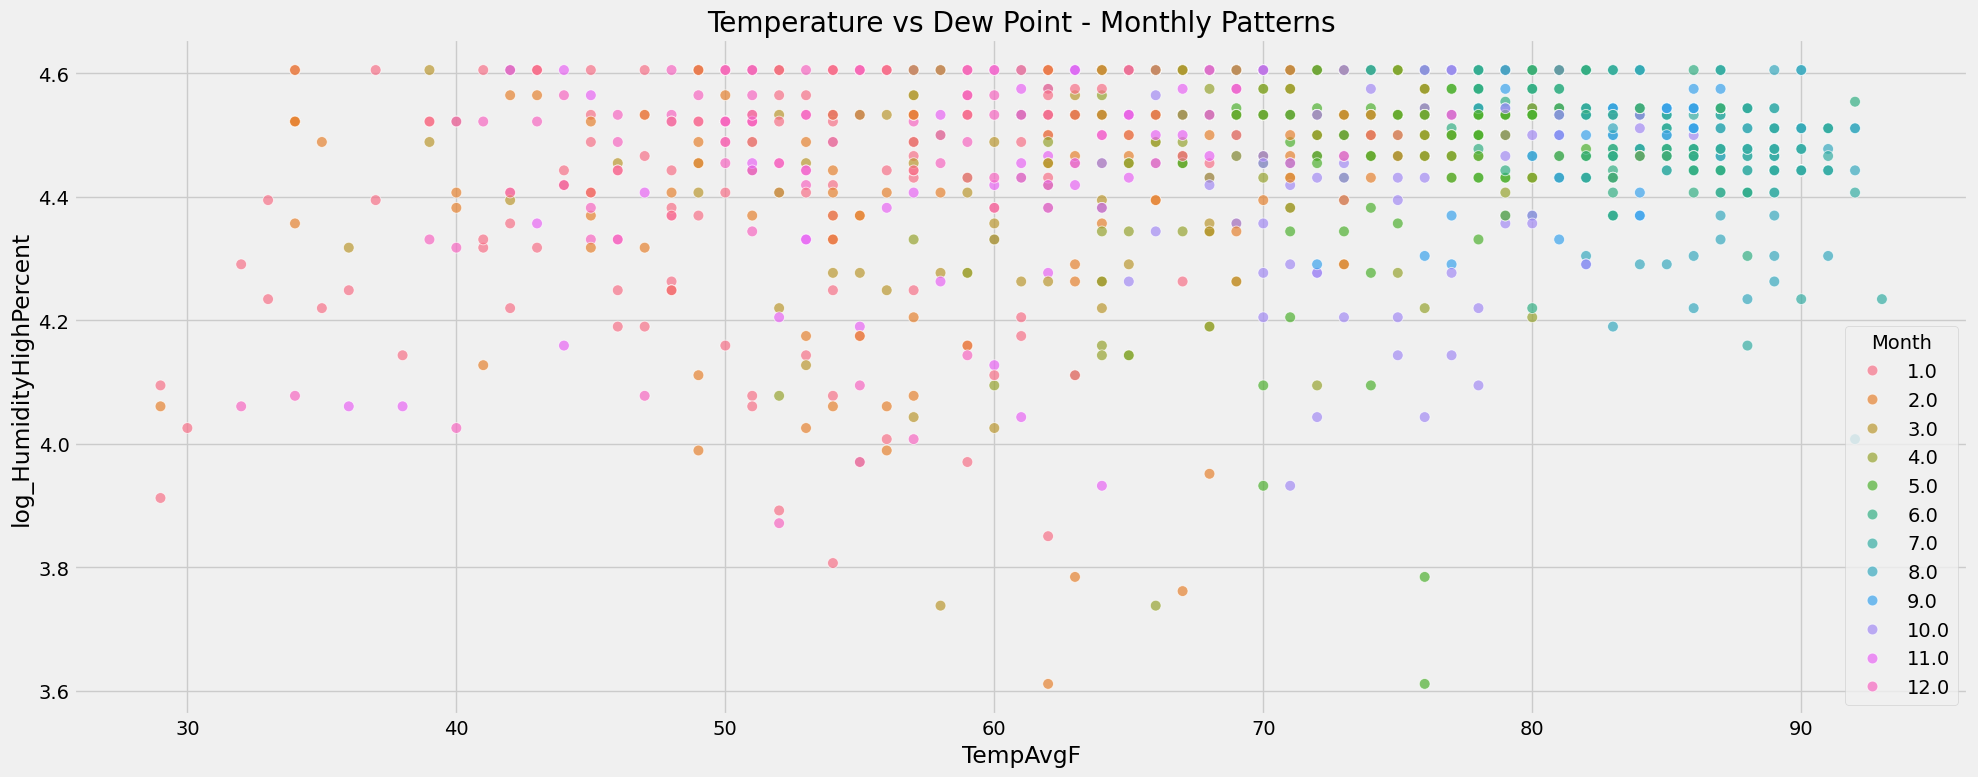

In [ ]:

month_palette = sns.color_palette("husl", 12)
plt.figure(figsize=(20, 8))
sns.scatterplot(data=numeric_subset, x='TempAvgF', y='log_HumidityHighPercent', hue='Month', palette=month_palette, alpha=0.7, s=60)
plt.title('Temperature vs Dew Point - Monthly Patterns')
plt.tight_layout()
plt.show()

Видим строго положительную связь между температурой и месяцом измерения. Оnношение не идеально линейное, но выглядит важным для предсказания средней температуры за день.

### **Парные графики**

Сделаем парные графики между некоторыми признаками. Используем функцию PairGrid. С её помощью мы можем составить разные графики на одном. Наша итоговая картина делится на три части: в диагонали полученного квадрата имеем гистограмму, снизу у нас корреляция между двумя переменными и 2-D оценкой ключеых взаимодействий двух переменных.

Text(0.5, 0.98, 'Парные графики')

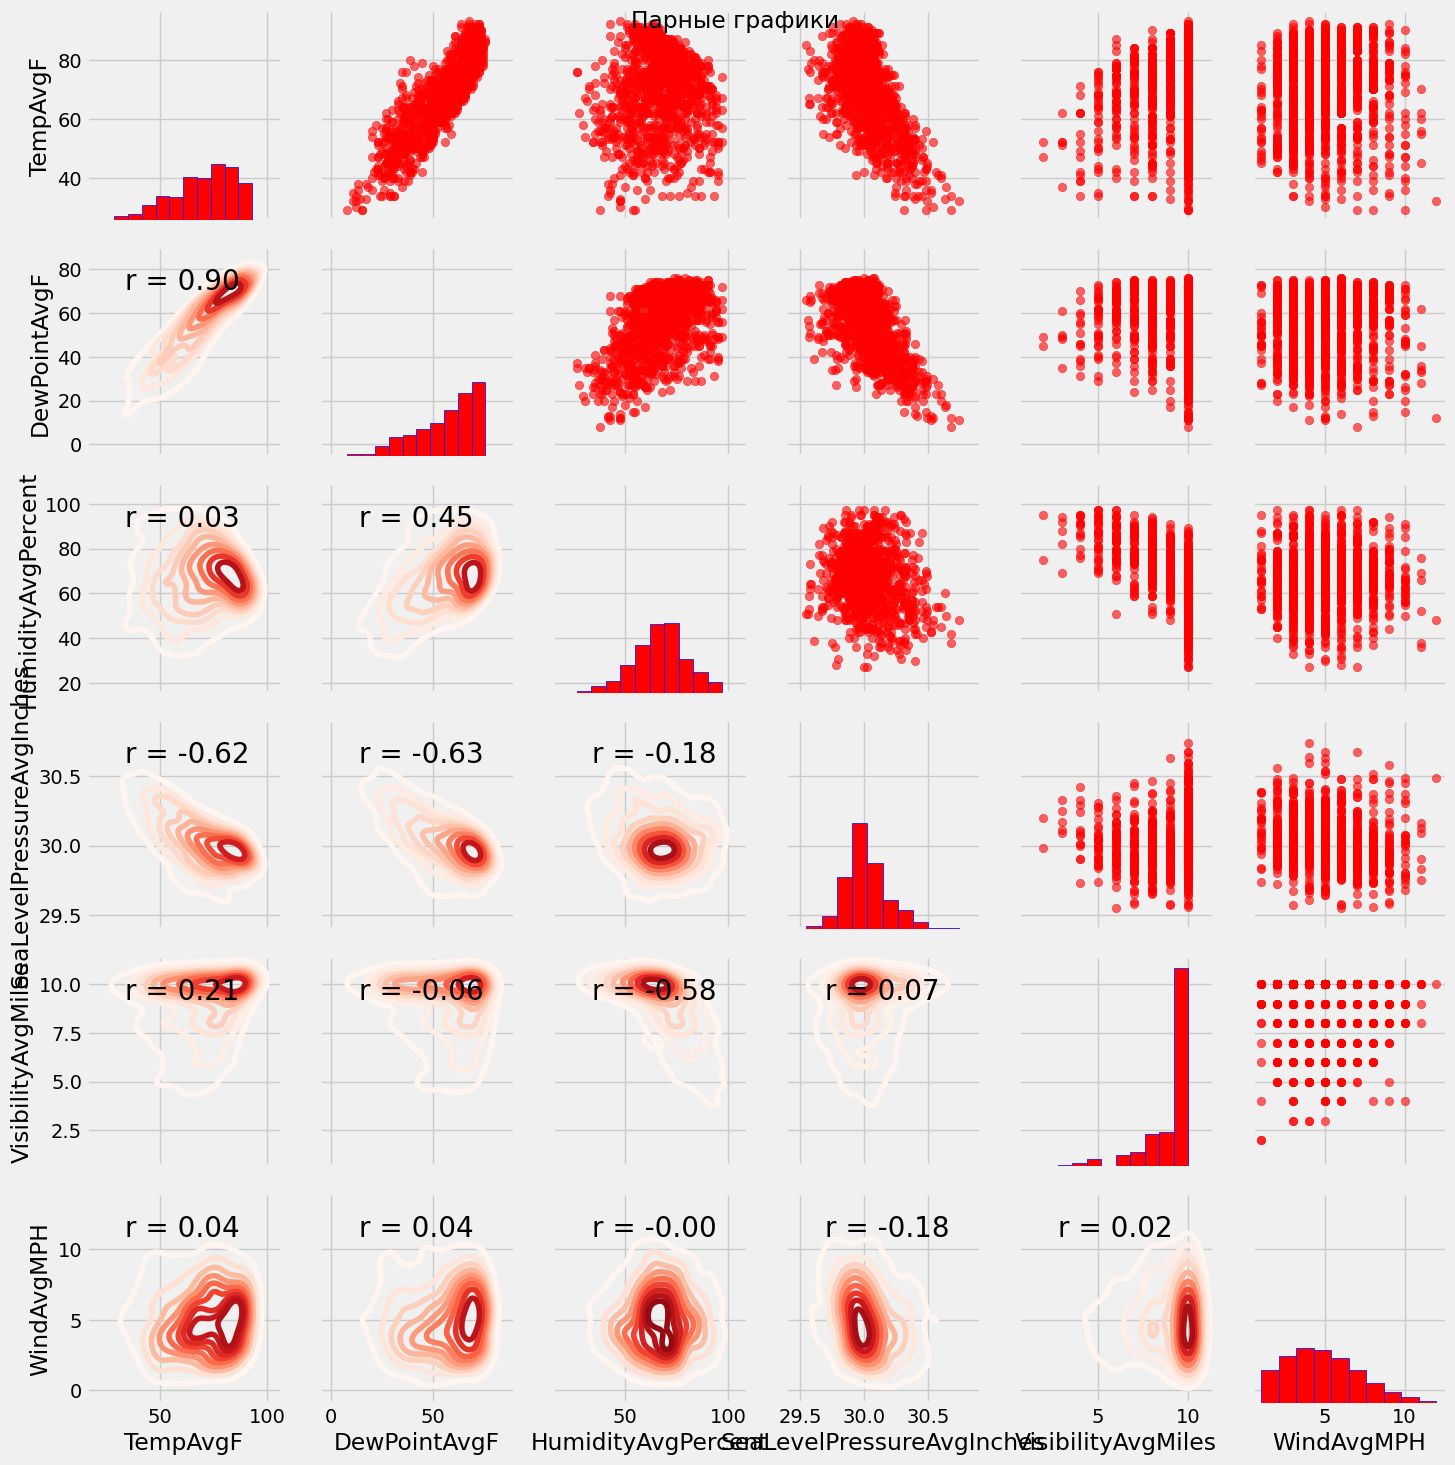

In [ ]:

plot_data = data[['TempAvgF', 'DewPointAvgF', 'HumidityAvgPercent', 'SeaLevelPressureAvgInches', 'VisibilityAvgMiles', 'WindAvgMPH']]

plot_data = plot_data.dropna()

def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)


grid = sns.PairGrid(data = plot_data)

grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)
grid.map_diag(plt.hist, color = 'red', edgecolor = 'blue')

grid.map_lower(corr_func)
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

plt.suptitle('Парные графики')

Видим интересное распределение у правой части scatterplot-а. Согласно, имеющимся у меня данным по итерпретации, эти графики значат, что связи между переменными нет. Это подтверждают и низкие коэффициенты корреляции.

После того как мы изучили отношения между данными, мы можем поработать над моделью.

В этом проекте будем следовать следующим шагам:


  1) Выберем только числовые признаки и категориальный признак(у нас это месяц)

  2) Добавим логарифмическую трансформацию к числовым признакам

  3) Произведём one-hot encode для месяцев



In [ ]:
features = data.copy()
numeric_subset = data.select_dtypes('float64')

for col in numeric_subset.columns:
    if col == 'TempAvgF' or col == 'Month':
        next
    else:
        numeric_subset['log_' + col] = np.log(np.where(numeric_subset[col] > 0, numeric_subset[col], np.nan))

categorical_subset = data[['Month']]
categorical_subset = pd.get_dummies(categorical_subset)
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
features.shape


(1319, 39)

### Удаление коллинеарный признаков

На данный момент имеем 1319 измерений с 39 разными признаками(один из которых средняя температура, то что мы, собственно, и хотим предсказать). Но не все признакми будут важны для предсказания температуры, в частности, из-за того что многие признаки излишни, так как высоко коллениарны друг с другом. Решим эту проблему удалением коллинеарных признаков.

Высоко коллинеарные признаки имеют существенный коэффициент корреляции между ними. Например, у нас очень высокая зависимость между самой высокой и средней температурой.

Text(0, 0.5, 'TempHighF')

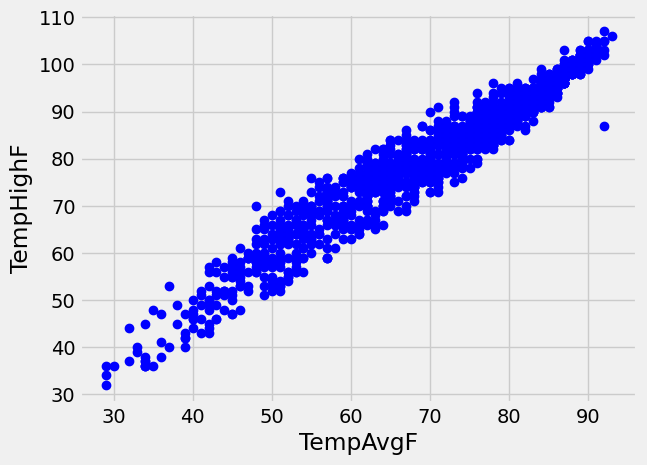

In [ ]:
plot_data = data[['TempAvgF', 'TempHighF']].dropna()
plt.plot(plot_data['TempAvgF'], plot_data['TempHighF'], 'bo')
plt.xlabel('TempAvgF')
plt.ylabel('TempHighF')

Пока признаки в датасете обычно не сильно коррелированы, высоко коррелированые признаки могут быть излишними в том смысле, что нам нужно опустить какой-то признак для того, чтобы дать нашей модели только необходимую информацию.

Убирание таких признаков - метод, чтобы упростить модель с помощью уменьшения номера признаков. И это может быть полезно для увеличения генерализации модели.

Будем использовать простую метрику и удалять некоторые признаки, если коррелиционный коэфициент выше некоторого порога. (корреляционный коэфициент не с тем признаком, который мы хотим предсказать, потому что нам нужны высоко коррелированные признаки для предсказания)



In [ ]:
def remove_collinear_features(x, threshold):
    y = x['TempAvgF']
    x = x.drop(columns = ['TempAvgF'])
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            if val >= threshold:
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    x = x.drop(columns = drops)

    x['TempAvgF'] = y

    return x

Убираем признаки, с коэффициентомм больше 0.6.

In [ ]:
features = remove_collinear_features(features, 0.6)
features  = features.dropna(axis=1, how = 'all')
print(features.shape)


(1319, 11)


В итоге получили 11 признаков, причём некоторые из них получены из one-hot кодирования.

Мы сначала извлечём все измерения, где не содержаться данные о средней температуре

In [ ]:
no_score = features[features['TempAvgF'].isna()]
score = features[features['TempAvgF'].notnull()]

print(no_score.shape)
print(score.shape)

(0, 11)
(1319, 11)


## Постановка задачи и построение модели


### Разделение на тестовую и тренировочную часть

А теперь разделим данные рандомно на тестовую и тренировочную часть(70 и 30 процентов соответственно)

In [ ]:
features = score.drop(columns='TempAvgF')
targets = pd.DataFrame(score['TempAvgF'])

features = features.replace({np.inf: np.nan, -np.inf: np.nan})

X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(923, 10)
(396, 10)
(923, 1)
(396, 1)


Получили значения тренировочных и тестовых частей.

### MAE and baseline

Вычислим среднюю абсолютную ошибку и показатель исходного базового уровня.

In [ ]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))
baseline_guess = np.median(y)

print('Показатель исходного базового уровня %0.2f' % baseline_guess)
print("Средняя абсолютная ошибка на тестовом наборе: MAE = %0.4f" % mae(y_test, baseline_guess))

Показатель исходного базового уровня 73.00
Средняя абсолютная ошибка на тестовом наборе: MAE = 11.4520


In [ ]:
train_features = X
test_features = X_test
train_labels = y
test_labels = y_test


### Заполнение

Чтобы избежать проблему с утечкой тестовых данных, мы делаем заполнение и не обучаем модель на данных как они есть, когда информация из тестового датасета переход в обучающий

In [ ]:
imputer = SimpleImputer(strategy='median')

imputer.fit(train_features)

X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

Проверим, пропущены ли какие то значения.

In [ ]:
print('Пропущенные значения в тренировочном датасете ', np.sum(np.isnan(X)))
print('Пропущенные значения в тестовом датасете:  ', np.sum(np.isnan(X_test)))

Пропущенные значения в тренировочном датасете  0
Пропущенные значения в тестовом датасете:   0


In [ ]:
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


В итоге все значения заполнены реальными значениями без пропусков.

### Масштабирование и нормализация

Будем масштабировать с помощью приведения каждого признака к диапазону от 0 до 1. Для этого необходимо взять все значения признака, выбрать из них минимальное и максимальное, для каждого другого значения расположим на этой шкале, получим в итоге диапазон. Этот процесс - нормализация.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

### Реализуем модели машинного обучения

Учим модель только на тестовом наборе, а только затем преобразуем все данные.

Конвертируем y в вектор.

In [ ]:
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

Возьмём модель, преобразуем её и оценим на тестовом наборе

Все модели индентичны, поэтому создаём функцию и прогоняем всевозможные модели через неё. Чтобы потом выбрать наиболее подходящую.

In [ ]:
def fit_and_evaluate(model):
    model.fit(X, y)
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    return model_mae

lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Линейная регрессия на тестовом сете: MAE = %0.4f' % lr_mae)

Линейная регрессия на тестовом сете: MAE = 0.2856


In [ ]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Производительность регрессии с использованием метода опорных векторов на тестовом наборе: MAE = %0.4f' % svm_mae)

Производительность регрессии с использованием метода опорных векторов на тестовом наборе: MAE = 0.3031


In [ ]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Градиент повышения производительности регрессии в тестовом наборе: MAE = %0.4f' % gradient_boosted_mae)

Градиент повышения производительности регрессии в тестовом наборе: MAE = 0.4502


In [ ]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest neighbors регрессия на тестовом сете: MAE = %0.4f' % knn_mae)

K-Nearest neighbors регрессия на тестовом сете: MAE = 1.7813


In [ ]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Регрессия рандомного леса на тестовом сете: MAE = %0.4f' % random_forest_mae)

Регрессия рандомного леса на тестовом сете: MAE = 0.3863


Чтобы оценить модели, мы вычислили медианное значение, с помощью него вычислили базовый уровень, а полученные нами результаты показал себя лучше, значит мы можем использовать машинное обучение для нашей задачи.

Text(0.5, 1.0, 'Model Comparison on Test MAE')

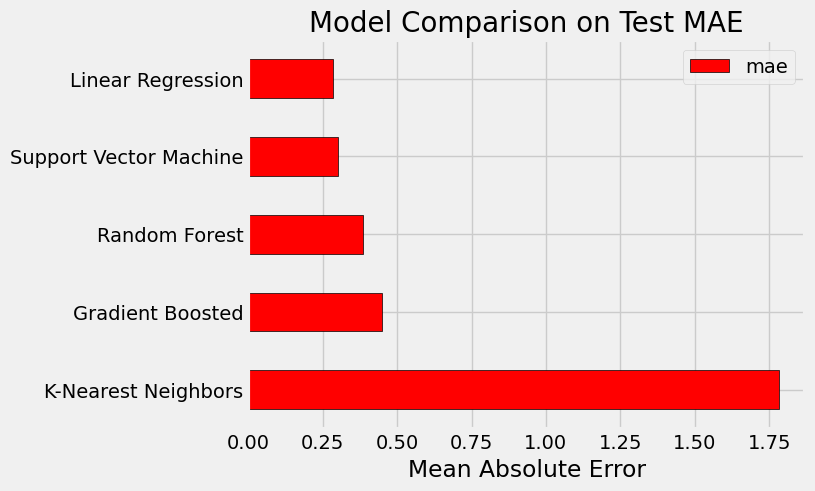

In [ ]:
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae,
                                         gradient_boosted_mae, knn_mae]})

model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',color = 'red', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20)

В нашем случае линейная регрессия показала себя лучше, чем другие методы.

### Гиперпараметрическая оптимизация модели

После выбора модели можно оптимизировать её под решаемую задачу, настраивая гиперпараметры. Изменяя их, можем влиять на недо - и переобучение модели.

In [ ]:
hyperparameter_grid = {'copy_X': [True],
                       'fit_intercept': [True],
                       'n_jobs': [1, 2 ,3],
                       'positive': [True]}
model = LinearRegression()
random_cv = RandomizedSearchCV(estimator=model, param_distributions=hyperparameter_grid,scoring = 'neg_mean_absolute_error', n_jobs = -1, return_train_score = True)

In [ ]:
random_cv.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=LinearRegression(), n_jobs=-1,
                   param_distributions={'copy_X': [True],
                                        'fit_intercept': [True],
                                        'n_jobs': [1, 2, 3],
                                        'positive': [True]},
                   return_train_score=True, scoring='neg_mean_absolute_error')

Мы будем использовать модель на основе линейной регрессии.

In [ ]:
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.001724      0.000256         0.001057        0.000075   
1       0.001494      0.000196         0.000968        0.000034   
2       0.001312      0.000021         0.001040        0.000119   

   param_positive  param_n_jobs  param_fit_intercept  param_copy_X  \
0            True             1                 True          True   
1            True             2                 True          True   
2            True             3                 True          True   

                                              params  split0_test_score  ...  \
0  {'positive': True, 'n_jobs': 1, 'fit_intercept...          -0.251169  ...   
1  {'positive': True, 'n_jobs': 2, 'fit_intercept...          -0.251169  ...   
2  {'positive': True, 'n_jobs': 3, 'fit_intercept...          -0.251169  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0        -0.253036        0.002692                1           -0.251581   
1        -0.253036        0.002692                1           -0.251581   
2        -0.253036        0.002692                1           -0.251581   

   split1_train_score  split2_train_score  split3_train_score  \
0           -0.251815           -0.250869           -0.249988   
1           -0.251815           -0.250869           -0.249988   
2           -0.251815           -0.250869           -0.249988   

   split4_train_score  mean_train_score  std_train_score  
0           -0.251841         -0.251219         0.000709  
1           -0.251841         -0.251219         0.000709  
2           -0.251841         -0.251219         0.000709  

[3 rows x 24 columns]

In [ ]:
random_cv.best_estimator_

LinearRegression(n_jobs=1, positive=True)

В линейной регрессии есть несколько гиперпараметров, которые нужно настраивать. Мы будем оптимизировать:

**'copy_X'** - если значение равно True, X будет скопирован; в противном случае он может быть перезаписан.

**'fit_intercept'**- следует ли вычислять точку пересечения с осью абсцисс для этой модели. Если установлено значение False, точка пересечения с осью абсцисс не будет использоваться в вычислениях, то есть предполагается, что данные центрированы,

**'n_jobs'**-количество заданий для выполнения вычислений. Это обеспечит ускорение только в случае достаточно больших задач,

**'positive'**- если установлено значение True, коэффициенты должны быть положительными. Эта опция поддерживается только для плотных массивов..

In [ ]:
trees_grid = {'copy_X': [True],
                       'fit_intercept': [True],
                       'n_jobs': [1, 2 , 3, 4, 5, 6, 7, 8, 9, 10],
                       'positive': [True]}
model = LinearRegression()
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid,n_jobs = -1, scoring = 'neg_mean_absolute_error', return_train_score = True)

In [ ]:
grid_search.fit(X, y)

GridSearchCV(estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True], 'fit_intercept': [True],
                         'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'positive': [True]},
             return_train_score=True, scoring='neg_mean_absolute_error')

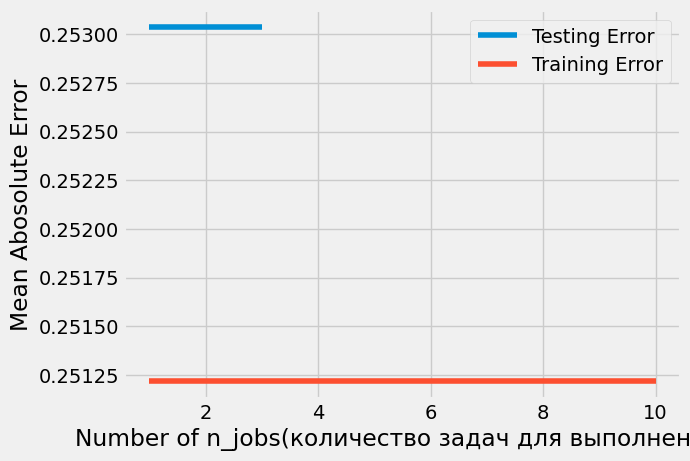

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
plt.style.use('fivethirtyeight')
plt.plot(random_results['param_n_jobs'], -1 * random_results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_jobs'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of n_jobs(количество задач для выполнения)')
plt.ylabel('Mean Abosolute Error')
plt.legend()


In [ ]:
results.sort_values('mean_test_score', ascending = False).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_n_jobs  \
0       0.001155      0.000146         0.000764        0.000105            -1   

           params  split0_test_score  split1_test_score  split2_test_score  \
0  {'n_jobs': -1}           0.999686           0.999647           0.999653   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           0.999561           0.999661         0.999641        0.000042   

   rank_test_score  
0                1

По этому графику ясно видно, что наша модель несколько переобучена. Тренировочная ошибка незначительно больше, чем тестовая, что показывает, что обучение модели данными прошло успешно, но ошибки при обучении снижаются куда быстрее, и в итоге модель показывает лучшие результаты на тестовых данных.
Проблема переобучения часто решается с помощью увеличения объёма обучающих данных.

### Оценка с помощью тестовых данных

Будем использовать лучшую модель для прогнозирования тестового набора. Учитываем, что наша модель никогда раньше не сталкивалась с тестовым набором, поэтому эта производительность должна быть хорошим показателем того, как модель будет работать при развертывании на реальных данных.

Чтобы сравнить, мы можем посмотреть на производительность модели по умолчанию. Приведенный ниже код создает окончательную модель, обучает ее (с указанием времени) и оценивает на тестовом наборе.

In [ ]:
default_model = LinearRegression()

final_model = grid_search.best_estimator_
final_model

LinearRegression(n_jobs=1, positive=True)

In [ ]:
%%timeit -n 1 -r 5
default_model.fit(X, y)


11.5 ms ± 1.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [ ]:
%%timeit -n 1 -r 5
final_model.fit(X, y)


1.98 ms ± 972 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [ ]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Стандартная модель на тестовом сете: MAE = %0.4f.' % mae(y_test, default_pred))
print('Финальная модель на тестовом сете: MAE = %0.4f.' % mae(y_test, final_pred))

Стандартная модель на тестовом сете: MAE = 0.2856.
Финальная модель на тестовом сете: MAE = 0.2854.


### Финальные результаты прогнозирования

Финальная модель действительно превзошла стандартную. Разница между ними примерно две сто тысячных, но за счет значительного увеличения времени работы (на моем компьютере это примерно в 6 раз медленнее)

Чтобы получить представление о прогнозах, мы можем построить график распределения истинных значений в тестовом наборе и прогнозируемых значений в тестовом наборе

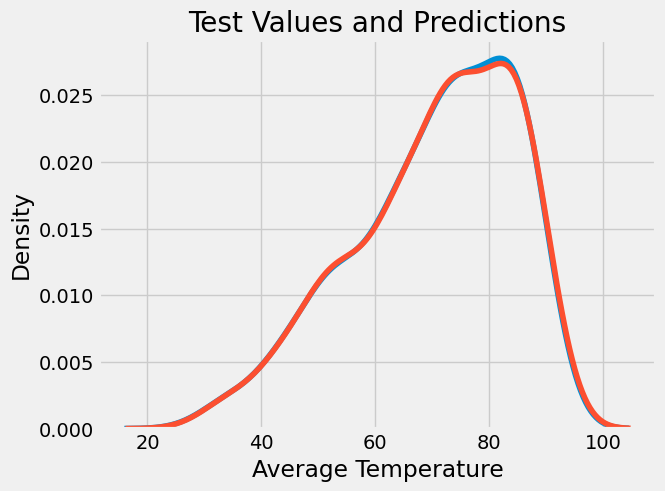

In [ ]:

sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

plt.xlabel('Average Temperature')
plt.ylabel('Density');
plt.title('Test Values and Predictions');

Распределение выглядит почти одинаковым, это означает, что модель достаточно хороша в предсказании.

### Распределение остатков

Отстатсками называем разницу между предсказанием и реальным значением


Другой график показывает гистограмму разницы между реальными и предсказываемыми значениями. В идеале, мы надеемся на нормальное распределение, что означает что модель ошибается одинаково в обоих направлениях

Text(0.5, 1.0, 'Distribution of Residuals')

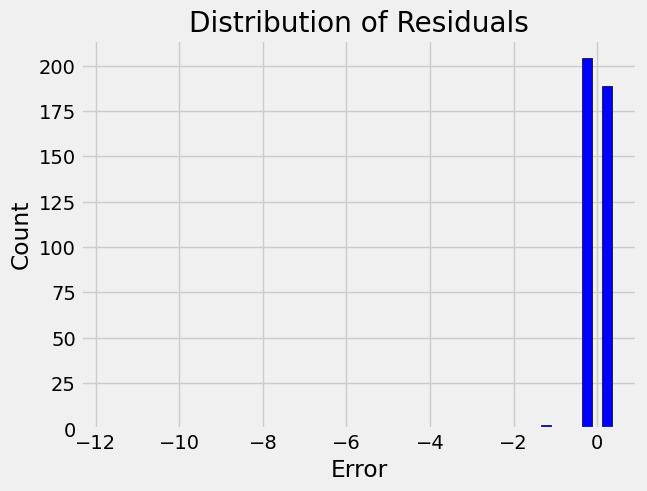

In [ ]:
residuals = final_pred - y_test

plt.hist(residuals, color = 'blue', bins = 50, edgecolor = 'black')
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of Residuals')

Глядя на этот график, сложно сказать, что разница имеет нормальное распределение, это показывает, на ошибки , когда оценка модели была намного ниже действительного значения.

Результаты показали нам, что машинное обучение применимо к нашей задаче, и окончательная модель способна предсказать среднюю температуру. Мы также увидели, что настройка гиперпараметров позволила повысить производительность модели, хотя и потребовала значительных затрат времени. Хорошее напоминание о том, что правильная разработка функций и сбор большего количества данных (только если это возможно!) приносят большую отдачу, чем тонкая настройка модели. Ещё нашли разницу между временем выполнения и точностью, что является одним из многих факторов, которые нужно учитывать при разработке моделей машинного обучения.

Мы знаем, что наша модель достаточно точна, но знаем ли мы, почему она делает такие прогнозы? Попытаемся понять, как модель делает прогнозы. Достижение высокой точности - это замечательно, но было бы также полезно, если бы мы могли выяснить, почему модель способна точно предсказывать, чтобы мы могли использовать эту информацию для лучшего понимания проблемы.

## Оценка модели и результатов

### Воссоздаём финальную модель

Создаём объект SimpleIputer, который может заполнять пропущенные значения с использованием стратегии медианы. Тренируем на тренировочных признаках. Трансформирует тренировочные и тестовые датасеты.

In [ ]:
imputer = SimpleImputer(strategy='median')
imputer.fit(train_features)

X = imputer.transform(train_features)
X_test = imputer.transform(test_features)
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [ ]:
model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1, positive=False)
model.fit(X, y)

LinearRegression(n_jobs=-1)

Создаём предсказания на тестовом сете.

In [ ]:
model_pred = model.predict(X_test)

print('Финальная модель на тестовом сете: MAE = %0.4f' % mae(y_test, model_pred))

Финальная модель на тестовом сете: MAE = 0.2856


### Интерпретация модели

Регрессия на основе градиентного бустинга располагается примерно посередине шкалы интерпретируемости моделей. Реализуем два способа, котрые помогут нам разобраться в работе нашей модели:

  1) Оценим важности признаков

  2) Применим метод LIME — Local Interpretable Model-Agnostic Explainations, локальные интерпретируемые моделезависимые объяснения.

Первые два метода характерны для ансамблей деревьев, а третий, как вы могли понять из его названия, можно применять к любой модели машинного обучения. LIME — относительно новый подход, это заметный шаг вперёд в попытке объяснить работу машинного обучения.


### Важность признаков

Один из основных способов, с помощью которого мы можем интерпретировать совокупность деревьев решений, - это так называемые значения признаков. Их можно интерпретировать как переменные, которые наиболее точно предсказывают цель. Хотя фактические данные о важности функций довольно сложны.

Извлечём значения объектов в виде фрейма данных, а потом покажем 10 самых важных

In [ ]:
feature_results = pd.DataFrame({
    'feature': train_features.columns,
    'coefficient': model.coef_,
    'abs_importance': np.abs(model.coef_)
})

feature_results = feature_results.sort_values('abs_importance', ascending=False).reset_index(drop=True)

print(feature_results.head(10))


                  feature  coefficient  abs_importance
0               TempHighF     0.503609        0.503609
1                TempLowF     0.495962        0.495962
2     VisibilityHighMiles     0.071794        0.071794
3  PrecipitationSumInches    -0.059218        0.059218
4      HumidityAvgPercent    -0.026838        0.026838
5      HumidityLowPercent     0.015536        0.015536
6     HumidityHighPercent     0.013011        0.013011
7              WindAvgMPH     0.006997        0.006997
8      VisibilityAvgMiles    -0.006591        0.006591
9             WindHighMPH    -0.003461        0.003461


Визуализируем

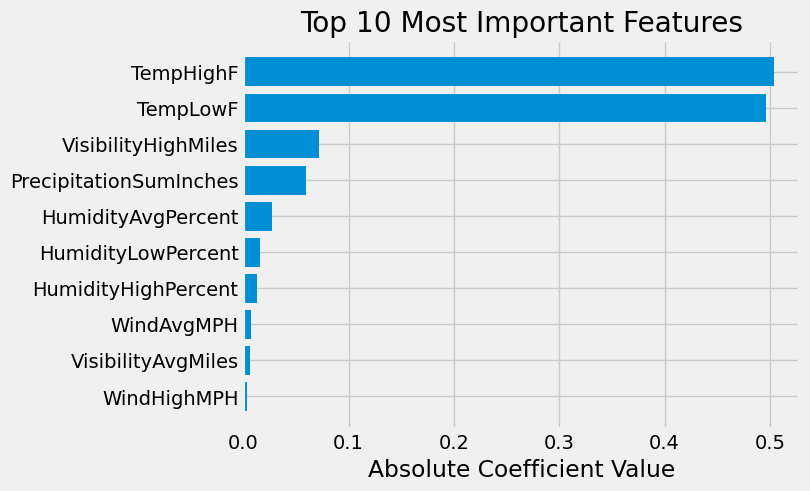

In [ ]:

plt.barh(feature_results['feature'][:10], feature_results['abs_importance'][:10])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.show()

Самые важные признаки - самая высокая и низкая температура, но мы не хотим ббрать их для предсказания. После этих признаков идут видимость в милях, сумма осадков и  влажность. После этого относительная важность значительно снижается, что указывает на то, что нам, возможно, не потребуется сохранять все функции для создания модели с почти такой же производительностью.

### Local Interpretable Model-Agnostic Explainations

Мы воспользуемся методом LIME, чтобы изучить совершенно ошибочный прогноз нашей модели и понять, почему она ошибается.

Сначала найдём этот неверный прогноз. Для этого обучим модель, сгенерируем прогноз и выберем значение с наибольшей ошибкой:


In [ ]:
residuals = abs(model_pred - y_test)

wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

Создадим lime explainer объект и передадим ему обучающие данные, информацию о режиме, метки для обучающих данных и имена признаков. Теперь можно передать explainer-у данные наблюдений и функцию прогнозирования, а потом попросить объяснить причину ошибочности прогноза.


In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced,
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Выведем предсказание и действительное(настоящее) значение для неверного прогноза. и посмотроим график объяснения предсказания

Предсказание: 83.6198
Настоящее значение: 92.0000


/tmp/ipython-input-1687642223.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Предсказание: %0.4f' % model.predict(wrong.reshape(1, -1)))


Text(0.5, 0, 'Effect on Prediction')

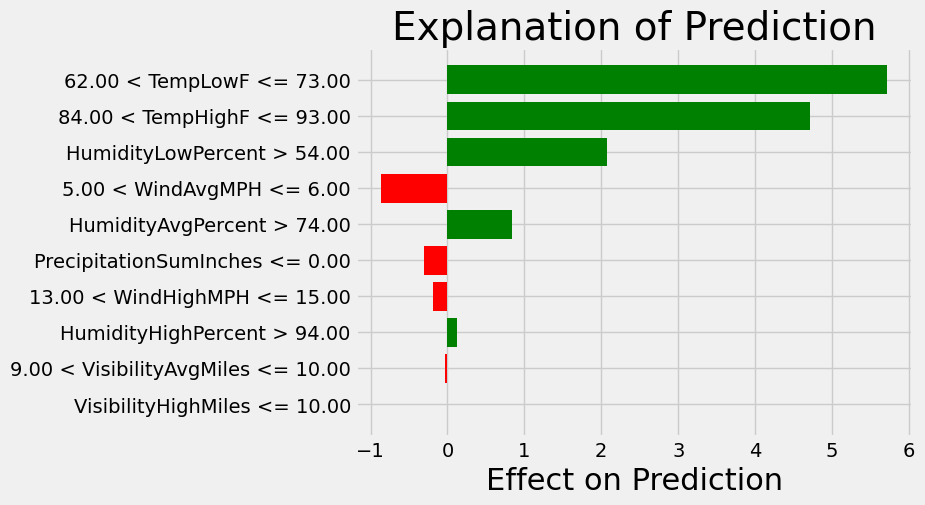

In [ ]:
print('Предсказание: %0.4f' % model.predict(wrong.reshape(1, -1)))
print('Настоящее значение: %0.4f' % y_test[np.argmax(residuals)])

wrong_exp = explainer.explain_instance(data_row = wrong, predict_fn = model.predict)

wrong_exp.as_pyplot_figure()
plt.title('Explanation of Prediction', size = 28)
plt.xlabel('Effect on Prediction', size = 22)

In [ ]:
wrong_exp.show_in_notebook(show_predicted_value=False)

предсказание было 83, а настоящее значение 92. График показывает нам вклад в итоговый прогноз каждой из характеристик для примера. Мы видим, что признак  TempLowF снизил прогноз, он был выше 62. С другой стороны, WindAvgMPH повысил прогноз, поскольку был ниже  5.

Мы можем интерпретировать это как то, что наша модель предполагала, что оценка средней температуры будет ниже, чем это было на самом деле, потому что  самая низкая температура была высокой. Однако в данном случае оценка составила 83, несмотря на высокое значение самой низкой температуры. Хотя эта существенная ошибка изначально могла сбить с толку, теперь мы видим, что на самом деле модель анализировала проблему и просто пришла к неверному значению. Человек, проделавший тот же процесс, вероятно, пришел бы к такому же выводу (если бы у него хватило терпения просмотреть все данные).

Теперь повторим тот же процесс, только с правильным прогнозом, который получила модель.

Prediction: 75.1953
Actual Value: 71.0000


/tmp/ipython-input-2635819365.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prediction: %0.4f' % model.predict(right.reshape(1, -1)))


Text(0.5, 0, 'Effect on Prediction')

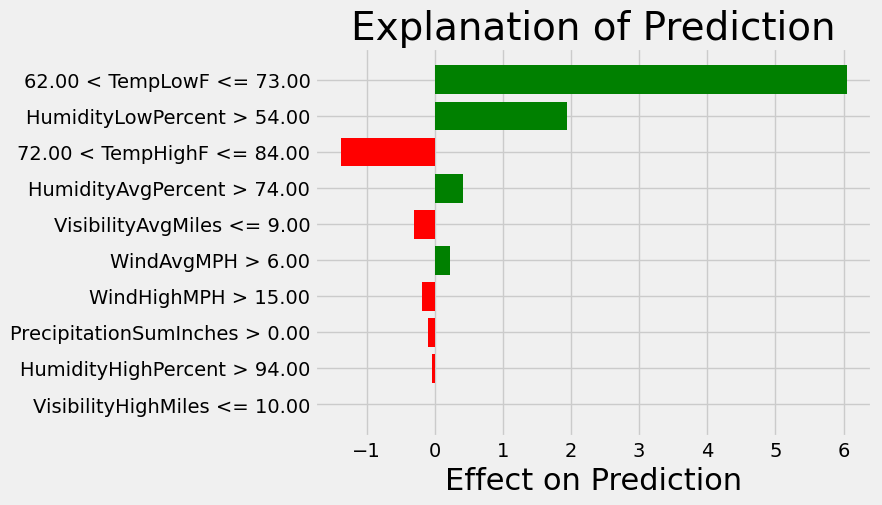

In [ ]:

print('Prediction: %0.4f' % model.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model.predict, num_features=10)
right_exp.as_pyplot_figure()
plt.title('Explanation of Prediction', size = 28)
plt.xlabel('Effect on Prediction', size = 22)

In [ ]:
right_exp.show_in_notebook(show_predicted_value=False)

Правильным значением для этого случая было 71, и наша градиентно-ускоренная модель почти правильно рассчитала это значение.(разница между правильным  и неправильным значением уменьшилась)

График из LIME снова показывает вклад в предсказание каждой из характерных переменных для примера. Негативно повлияла самая высокая температура.

Наблюдение за графиками разбивки, подобными этим, позволяет нам получить представление о том, как модель делает прогноз. Это наиболее ценно в тех случаях, когда модель сильно сбивается, поскольку мы можем проверить ошибки и, возможно, разработать лучшие функции или скорректировать гиперпараметры модели, чтобы улучшить прогнозы на следующий раз. Примеры, в которых модель дает наибольшие сбои, также могут быть интересными примерами, которые можно рассмотреть вручную. В модели был значительно занижен балл самой низкой теммпературы и  средней скорости света. Поэтому мы скорее всего захотим спросить, почему измерение получило такую высокую среднюю температуру, несмотря на то, что у него такоее большое значение самый высокой температуры за день. Подобный процесс, когда мы пытаемся работать с алгоритмом машинного обучения, чтобы лучше понять проблему, кажется намного лучше, чем просто позволить модели делать прогнозы и полностью доверять им. Помним про то, что LIME не идеален, он представляет собой шаг в правильном направлении к объяснению моделей машинного обучения.

## Вывод

Мы разработали модель машинного обучения, которая предсказывает среднюю температуру определённого города(Остин, Техас). Можем распространить эту модель на другие города и улучшить гиперпараметры для лучшего прогнозирования. Проект имеет пути для расширения и улучшения.